In [39]:
# 图片样式迁移学习：
#论文pdf: https://openaccess.thecvf.com/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
# -----------------#
 # mxnet-GPU
 # vgg-19, cuda, cuDNN, nvidia, ubuntu 
#大体流程
 #1. 准备基准图像和风格图像
 #2. 使用深层网络分别提取基准图像（加白噪声）和风格图像的特征向量（或者说是特征图feature map）
 #3. 分别计算两个图像的特征向量的Gram矩阵，以两个图像的Gram矩阵的差异最小化为优化目标，不断调整基准图像，使风格不断接近目标风格图像

In [41]:
#载入需要的模块

import matplotlib.pyplot as plt #图片读取，显示
from mxnet import autograd, gluon, image, init, nd #mxnet,自动求梯度，gluon, 图片，初始化，nd.array()
from mxnet.gluon import model_zoo, nn
import time


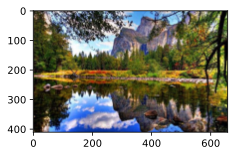

In [36]:
# 图片载入， 内容图像
content_img = image.imread('/home/lzj/桌面/hill.jpeg')
plt.imshow(content_img.asnumpy());

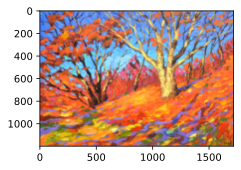

In [42]:
# 图片载入， 样式图像
style_img = image.imread('/home/lzj/桌面/autumn_oak.jpg')
plt.imshow(style_img.asnumpy());

In [43]:
#图像的预处理函数和后处理函数， 
#预处理函数preprocess对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式
#后处理函数postprocess则将输出图像中的像素值还原回标准化之前的值；


rgb_mean = nd.array([0.485, 0.456, 0.406])#参数可改
rgb_std = nd.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):#预处理
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return img.transpose((2, 0, 1)).expand_dims(axis=0)

def postprocess(img):#后处理
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1, 2, 0)) * rgb_std + rgb_mean).clip(0, 1)

In [5]:
#载入在ImageNet数据集预训练的VGG-19模型来抽取图像特征；

pretrained_net = model_zoo.vision.vgg19(pretrained=True)

In [44]:
#选择VGG网络中某些层的输出，作为抽取图像的内容特征和样式特征；
# 内容层：为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层
# 样式层：从VGG中选择不同层的输出来匹配局部和全局的样式；

style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [45]:
#因为在抽取特征时，只需要用到VGG从输入层到最靠近输出层的内容层或样式层之间的所有层。
#下面构建一个新的网络  net， 仅保留从输入到这些层的最后一层

net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

In [46]:
# 保留中间指定层的输出，因此这里我们逐层计算，并保留内容层和样式层的输出；

def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [47]:
#get_contents函数 对内容图像抽取内容特征， 之后不再改变
#get_styles函数 对样式图像抽取样式特征， 之后不再改变


def get_contents(image_shape, ctx):
    content_X = preprocess(content_img, image_shape).copyto(ctx)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, ctx):
    style_X = preprocess(style_img, image_shape).copyto(ctx)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [10]:
# 定义损失函数

def content_loss(Y_hat, Y): # 内容损失
    return (Y_hat - Y).square().mean()


def gram(X): # 通过 格拉姆矩阵来计算样式损失
    num_channels, n = X.shape[1], X.size // X.shape[1]
    X = X.reshape((num_channels, n))
    return nd.dot(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y): # gram 矩阵平方差
    return (gram(Y_hat) - gram_Y).square().mean()


#为了防止出现大量高频噪点，即有特别亮或者特别暗的颗粒像素。一种常用的降噪方法是总变差降噪（
def tv_loss(Y_hat): #
    return 0.5 * ((Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).abs().mean() +
                  (Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).abs().mean())

In [11]:
#样式迁移的损失函数即内容损失、样式损失和总变差损失的加权和
#通过调节这些权值超参数，我们可以权衡合成图像在保留内容、迁移样式以及降噪三方面的相对重要性

content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = nd.add_n(*styles_l) + nd.add_n(*contents_l) + tv_l
    return contents_l, styles_l, tv_l, l



In [12]:
#样式迁移中，合成图像是唯一需要更新的变量
#我们可以定义一个简单的模型，并将合成图像视为模型参数。模型的前向计算只需返回模型参数

class GeneratedImage(nn.Block): #mxnet 中模型定义方法，继承自Block模块
    def __init__(self, img_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self): #前向计算
        return self.weight.data()

In [13]:
#函数创建了合成图像的模型实例，并将其初始化为图像X

def get_inits(X, ctx, lr, styles_Y):
    gen_img = GeneratedImage(X.shape) #图像实例
    gen_img.initialize(init.Constant(X), ctx=ctx, force_reinit=True)#初始化
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam',
                            {'learning_rate': lr})#训练方法
    styles_Y_gram = [gram(Y) for Y in styles_Y] #样式损失
    return gen_img(), styles_Y_gram, trainer

In [14]:
#在训练模型时，不断抽取合成图像的内容特征和样式特征，并计算损失函数
#使用同步函数 nd.waitall(), 防止内存占用过高

def train(X, contents_Y, styles_Y, ctx, lr, max_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, ctx, lr, styles_Y)#初始化
    for i in range(max_epochs):
        start = time.time()
        with autograd.record():# mxneet 中梯度计算
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers) #返回当前内容和样式损失
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram) #当前损失计算
        l.backward() #反向传播, 计算和存储参数梯度以及中间变量
        trainer.step(1) # 参数更新
        nd.waitall() #同步函数
        if i % 50 == 0 and i != 0: #每50个周期打印一次
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                  'TV loss %.2f, %.2f sec'
                  % (i, nd.add_n(*contents_l).asscalar(),
                     nd.add_n(*styles_l).asscalar(), tv_l.asscalar(),
                     time.time() - start))
        if i % lr_decay_epoch == 0 and i != 0:#每lr_decay_epoch个周期， 学习率变为原来的1/10
            trainer.set_learning_rate(trainer.learning_rate * 0.1) 
            print('change lr to %.1e' % trainer.learning_rate)
    return X

In [15]:
#开始训练模型。首先将内容图像和样式图像的高和宽分别调整为150和225像素。
#合成图像将由内容图像来初始化。


ctx, image_shape = mx.gpu(), (225, 150)
net.collect_params().reset_ctx(ctx)# 参数在 ctx 指定的设备上初始化， gpu
content_X, contents_Y = get_contents(image_shape, ctx) # 不变量
_, styles_Y = get_styles(image_shape, ctx) #不变量
output = train(content_X, contents_Y, styles_Y, ctx, 0.01, 500, 200)# 开始训练

epoch  50, content loss 6.99, style loss 22.31, TV loss 4.82, 0.10 sec
epoch 100, content loss 5.36, style loss 10.85, TV loss 4.92, 0.11 sec
epoch 150, content loss 4.66, style loss 7.34, TV loss 5.00, 0.11 sec
epoch 200, content loss 4.23, style loss 6.00, TV loss 4.99, 0.10 sec
change lr to 1.0e-03
epoch 250, content loss 4.19, style loss 5.90, TV loss 4.99, 0.11 sec
epoch 300, content loss 4.15, style loss 5.81, TV loss 4.98, 0.11 sec
epoch 350, content loss 4.12, style loss 5.72, TV loss 4.97, 0.10 sec
epoch 400, content loss 4.08, style loss 5.63, TV loss 4.96, 0.10 sec
change lr to 1.0e-04
epoch 450, content loss 4.07, style loss 5.61, TV loss 4.96, 0.10 sec


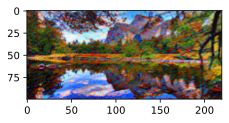

In [49]:
#将训练好的合成图像保存起来, 并显示
plt.imsave('/home/lzj/桌面/neural-style-1.png', postprocess(output).asnumpy())
out_img = image.imread("/home/lzj/桌面/neural-style-1.png")
plt.imshow(out_img.asnumpy())